# Plot NCEP/NCAR Reanalysis fields as well as parameters computed from those fields (e.g., geopotential thickness).

The following line will produce plots within the notebook instead of as separate windows. If you want a separate window, delete the cell or comment the line within the cell with a # sign at the beginning of it.

In [1]:
#%matplotlib inline

In [2]:
from datetime import datetime
from metpy.units import units
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import metpy.calc as mpcalc
import numpy as np
import warnings
import xarray as xr

### Provide the map domain bounds (latitude and longitude), the date of interest, and the field you'd like to plot in the below cell.

In [3]:
minlat = 26.                # CONUS min: 26.
maxlat = 49.                # CONUS max: 49.
minlon = -125.              # CONUS min: -125.
maxlon = -70.               # CONUS max: -70.
date_string = '2024030112'  # Example string -- '2020040100' equates to 00 UTC 1 April 2020
output = 'thickness'        # geopotential thickness | height | wind | rh
level = 500                 # Optional argument for pressure-level fields
geog_color = 'k'            # Color of coastlines, borders, etc.

In [4]:
dt = datetime.strptime(date_string, '%Y%m%d%H')
PNGname = dt.strftime('NCEP-NCAR-map_%Y%m%d%H.png')
if output == 'thickness' or output == 'height':
    ds = xr.open_dataset(dt.strftime('http://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis2/pressure/hgt.%Y.nc'))
elif output == 'wind':
    ds = {'u': xr.open_dataset(dt.strftime('http://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis2/pressure/uwnd.%Y.nc')),
          'v': xr.open_dataset(dt.strftime('http://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis2/pressure/vwnd.%Y.nc'))}
elif output == 'rh':
    ds = xr.open_dataset(dt.strftime('http://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis2/pressure/rhum.%Y.nc'))

### Custom functions are provided in the below cell.

<em>(You should NOT need to make any changes to these functions. Pay attention to the doc strings for expected arrays and units.)</em><br />
'<span style="font-family:monospace;">addgridlines()</span>' adds nice-looking latitude and longitude lines + labels to map.<br />
'<span style="font-family:monospace;">addcolorbar()</span>' adds a reasonably-sized colorbar to the figure.

In [5]:
def addgridlines(axes):
    """
    axes is the axis object ('ax')
    """
    gl = axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.5)
    gl.xlocator = mticker.FixedLocator(np.arange(-180.,0.,5.))
    gl.ylocator = mticker.FixedLocator(np.arange(0.,61.,5.))
    gl2 = axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0., alpha=0.)
    gl2.rotate_labels = False  # disable rotated lat/lon labels
    gl2.top_labels = False     # turn off labels along top x-axis
    gl2.right_labels = False   # turn off labels along right y-axis
    gl2.xlocator = mticker.FixedLocator(np.arange(-180.,0.,5.))
    gl2.ylocator = mticker.FixedLocator(np.arange(0.,61.,5.))
    gl2.xlabel_style = {'size': 12}  # change font size for longitude labels
    gl2.ylabel_style = {'size': 12}  # change font size for latitude labels

def addcolorbar(figobject, axes, contourdata, ticks):
    """
    figobject is the figure object ('fig')
    axes is the axis object ('ax')
    contourdata is the result from calling contourf()
    ticks are the values to be labeled on the colorbar
    cbar_title is the label to add to the colorbar
    """
    axes_bbox = axes.get_position()
    width = 0.3
    height = 0.015
    left = axes_bbox.x1 - width
    bottom = axes_bbox.y1 + 0.025
    cax = figobject.add_axes([left, bottom, width, height])
    cbar = plt.colorbar(contourdata, cax=cax, ticks=ticks, orientation='horizontal', extendfrac='auto')
    cbar.ax.tick_params(labelsize=10)
    cbar.ax.xaxis.set_ticks_position('top')

### The remainder of the script pulls NCEP NCAR reanalysis data from a NOAA THREDDS server for the desired date and time. No need to modify below code unless you're adding fields to be displayed, changing contour level values, etc.

In [6]:
#### Confirm that provided longitudes are negative if in Western Hemisphere (instead of 0-360 format).
if minlon > 180.:
    minlon -= 360.
if maxlon > 180.:
    maxlon -= 360.

#### Map settings.
pc = ccrs.PlateCarree()
map_scale = '10m'
borders = cfeature.BORDERS.with_scale(map_scale)
states = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines', scale=map_scale, 
                                      facecolor='none')
lakes = cfeature.LAKES.with_scale(map_scale)
coastline = cfeature.COASTLINE.with_scale(map_scale)
cenlon = (maxlon-minlon)/2. + minlon
cenlat = (maxlat-minlat)/2. + minlat
merc = ccrs.Mercator(central_longitude=cenlon, latitude_true_scale=cenlat)

In [7]:
#### Obtain desired field(s) from NCEP/NCAR xarray Dataset.
Xslice = slice(minlon+360.-3., maxlon+360.+3.)
Yslice = slice(maxlat+3., minlat-3.)  # NCEP/NCAR data starts at 90N
TT = np.datetime64(dt)
if output == 'thickness':
    ## defaults to 1000-500-hPa thickness; change levels in below line if you'd like a different layer
    data = ds['hgt'].sel(time=TT,level=500,lat=Yslice,lon=Xslice).values - ds['hgt'].sel(time=TT,level=1000,lat=Yslice,lon=Xslice).values
elif output == 'height':
    data = ds['hgt'].sel(time=TT,level=level,lat=Yslice,lon=Xslice).values
elif output == 'wind':
    uwind = ds['u']['uwnd'].sel(time=TT,level=level,lat=Yslice,lon=Xslice).values
    uwind_kt = (uwind * units('m/s')).to('kt').m  # convert m/s to kt
    vwind = ds['v']['vwnd'].sel(time=TT,level=level,lat=Yslice,lon=Xslice).values
    vwind_kt = (vwind * units('m/s')).to('kt').m  # convert m/s to kt
elif output == 'rh':
    data = ds['rhum'].sel(time=TT,level=level,lat=Yslice,lon=Xslice).values

#### Create 2-D latitude and longitude grids for plotting
lon = ds['lon'].sel(lon=Xslice).values
lon[lon>180.] -= 360.
lat = ds['lat'].sel(lat=Yslice).values
lon2d, lat2d = np.meshgrid(lon, lat)

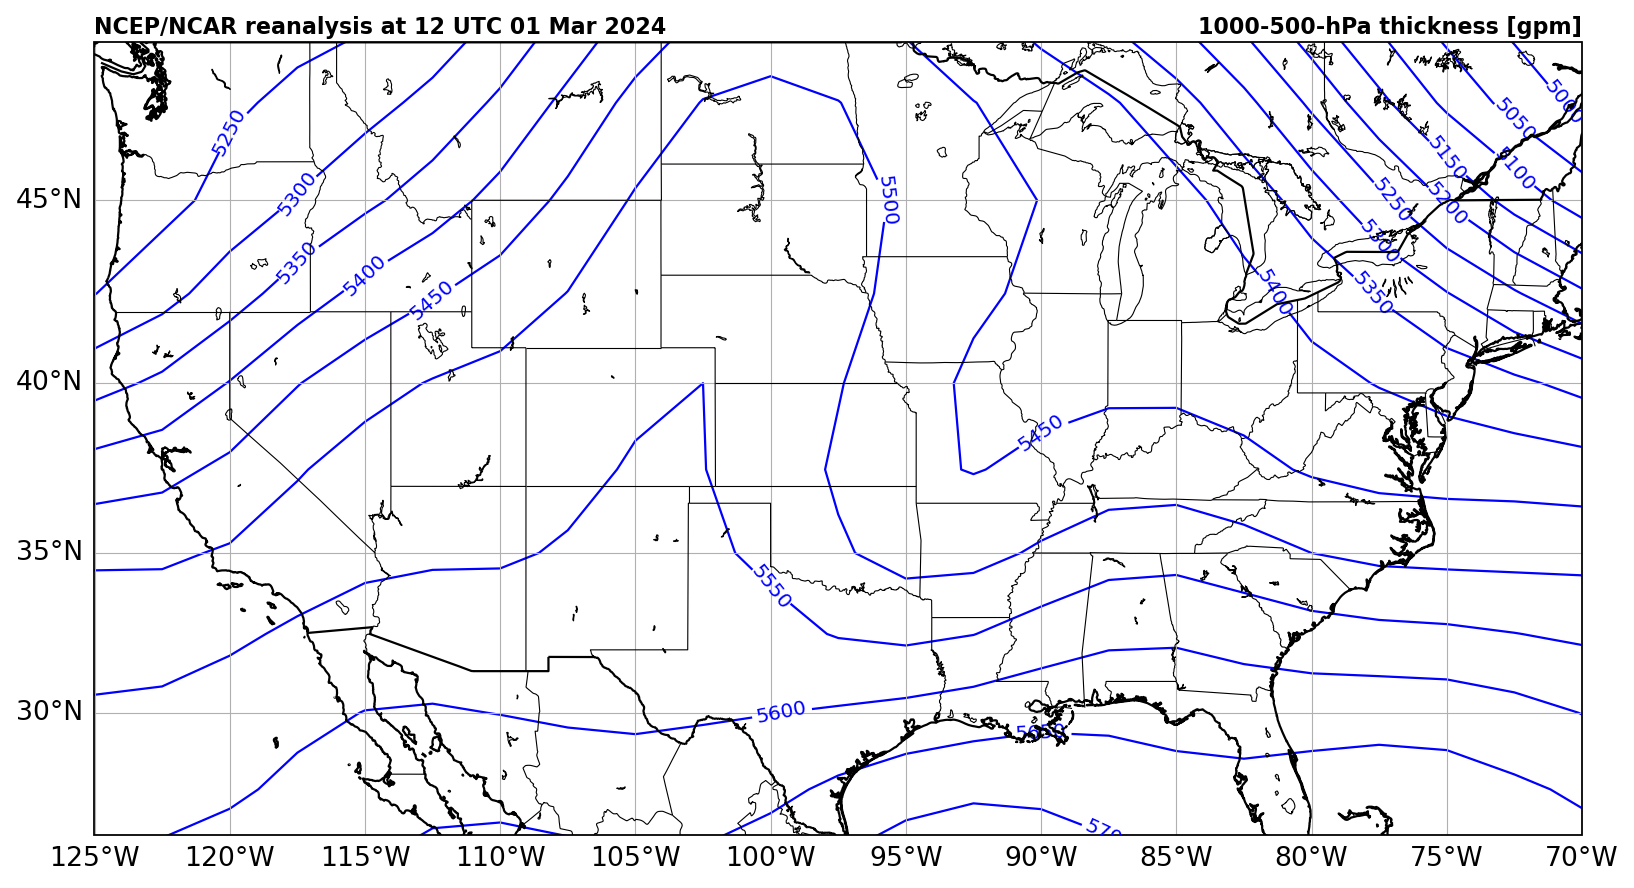

In [8]:
#### Create the plot!
fig = plt.figure(figsize=(12,9), dpi=160)
ax = fig.add_subplot(1, 1, 1, projection=merc)
ax.set_extent([minlon-0.01, maxlon+0.01, minlat-0.01, maxlat+0.01], crs=pc)
if output == 'wind':
    ax.barbs(lon, lat, uwind_kt, vwind_kt, pivot='tip', zorder=50, color='b', length=5, linewidth=0.75, transform=pc, sizes={'emptybarb': 0})
    right_title = '%d-hPa winds [kt]' % level
    PNGname = 'NCEP-NCAR-wind%d_%s.png' % (level,dt.strftime('%Y%m%d%H'))
elif output == 'thickness' or output == 'height':
    cl = ax.contour(lon2d, lat2d, data, np.arange(0,10001,50), colors='b', linewidths=1., transform=pc, transform_first=True)
    ax.clabel(cl, cl.levels, inline=True, fmt='%d', fontsize=9)
    if output == 'thickness':
        right_title = '1000-500-hPa thickness [gpm]'
        PNGname = 'NCEP-NCAR-thickness_%s.png' % dt.strftime('%Y%m%d%H')
    else:
        right_title = '%d-hPa geopotential height [gpm]' % level
        PNGname = 'NCEP-NCAR-ght%d_%s.png' % (level,dt.strftime('%Y%m%d%H'))
elif output == 'rh':
    tick_levels = np.arange(10,91,5)
    im = ax.contourf(lon2d, lat2d, data, tick_levels, cmap=plt.get_cmap('BrBG'), extend='both', transform=pc, transform_first=True)
    addcolorbar(fig, ax, im, tick_levels[::2])
    right_title = '%d-hPa relative humidity [%%]' % level
    PNGname = 'NCEP-NCAR-rh%d_%s.png' % (level,dt.strftime('%Y%m%d%H'))

ax.add_feature(coastline, linewidth=1., edgecolor=geog_color, zorder=10)
ax.add_feature(borders, linewidth=1., edgecolor=geog_color, zorder=10)
ax.add_feature(states, linewidth=0.5, edgecolor=geog_color, zorder=10)
ax.add_feature(lakes, linewidth=0.5, edgecolor=geog_color, facecolor='none', zorder=10)
addgridlines(ax)
left_title = dt.strftime('NCEP/NCAR reanalysis at %H UTC %d %b %Y')
pos = ax.get_position()
TF = fig.transFigure
ax.text(pos.x0, pos.y1+0.002, left_title, ha='left', va='bottom', transform=TF, weight='bold', size=10)
ax.text(pos.x1, pos.y1+0.002, right_title, ha='right', va='bottom', transform=TF, weight='bold', size=10)
#### Save the image as a PNG file
plt.savefig(PNGname, dpi=120, bbox_inches='tight', pad_inches=0.05)  # comment this line to avoid saving image
plt.show()
#plt.close()